<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/GAN/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:

Utilize a generative adversarial network (GAN) to train a generator that transforms pure random numbers (noise) into MNIST digits.

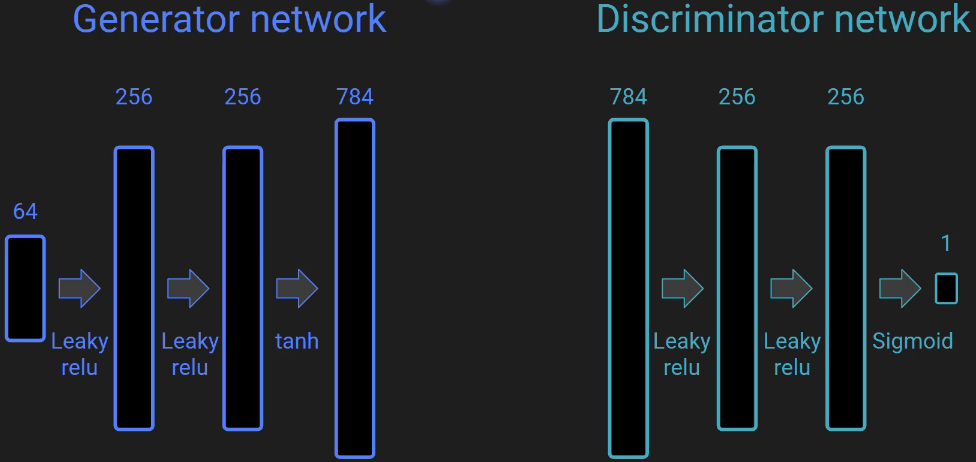

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import data:

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need the labels here
data = data[:,1:]

# normalize & re-range to [-1,1] (b/c tanh output)
dataNorm = data / np.max(data) # normalize to [0,1]
dataNorm = 2*dataNorm - 1 # [0,1] -> [0,2] -> [-1,1]

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# no dataloaders!
batchsize = 100

# Create classes for the discriminator and generator:

In [ ]:
# create a class for the discriminator network:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28*28,256) # 28^2=784
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )


# create a discriminator instance:
dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

In [ ]:
# create a class for the generator network:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


# create a generator instance:
gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

# Train the model:

In [ ]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss() # for two possible answers (through Sigmoid return 0 or 1)

# create instances of the models
dnet = discriminatorNet().to(device) # discriminator network
gnet = generatorNet().to(device) # generator network

# two separate optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [ ]:
# this cell takes ~3 mins with 50k epochs
num_epochs = 50000 # b/c lr is tiny

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) # disDecs: discriminator decisions

for epochi in range(num_epochs):

  # create minibatches of REAL and FAKE images
  randidx     = torch.randint(dataT.shape[0],(batchsize,))
  real_images = dataT[randidx,:].to(device) # real imgs: random imgs from the real data
  fake_images = gnet( torch.randn(batchsize,64).to(device) ) # fake imgs: output of generator network

  # (dummy coded) labels for real and fake images
  real_labels = torch.ones(batchsize,1).to(device) # 1 for True
  fake_labels = torch.zeros(batchsize,1).to(device) # 0 for False

  # ---------------- phase 1: Train the discriminator ----------------

  # (forward pass) input all real images into the discriminator & return all "Real" in the loss function
  pred_real   = dnet(real_images)              # all ones
  d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

  # (forward pass) input all fake images into the discriminator & return all "Fake" in the loss function
  pred_fake   = dnet(fake_images)              # all zeros
  d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0

  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake # or `d_loss = d_loss_real + d_loss_fake*2` to emphasize `d_loss_fake`
  # store the model's decisions
  losses[epochi,0]  = d_loss.item()
  disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

  # backprop of the discriminator network
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()

  # ---------------- phase 2: Train the generator ----------------

  # create new fake images
  fake_images = gnet( torch.randn(batchsize,64).to(device) )
  pred_fake   = dnet(fake_images)

  # compute and collect loss and accuracy
  g_loss = lossfun(pred_fake,real_labels) # fake img w/ real_labels -> lying to the discriminator
  losses[epochi,1]  = g_loss.item()
  disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()

  # backprop of the generator network
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()

  # ---------------------------------------------------------------

  # print out a status message
  if (epochi+1)%500==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

👆 the better the generator is doing, the worse the discriminator is doing (the generator is constantly getting better and better at fooling the discriminator) -> negatively correlated

# Let's see some fake digits:

In [ ]:
# generate the images from the generator network
gnet.eval() # speeds up the model performance & switch off batch normalization and dropout (althouth we don't have them here)
fake_data = gnet(torch.randn(12,64).to(device)).cpu() # send data to GPU as the model is there, then bring data back into CPU

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()